## 基于timestamp的事件重构b-重离子和衰变事件的关联
数据：sort.root (按照上一次课件的描述生成root文件）

TTree Branch: 
- timestamp, xstrip, ystrip, de //de- dssd front energy
- me //mwpc energy, me<0 when no dssd signal

In [1]:
TCanvas *c1=new TCanvas("c1","c1");
TFile *fin=new TFile("sort1.root");
TTree *tree=(TTree*)fin->Get("tree");
tree->Print();
ULong64_t timestamp;
Int_t xstrip,ystrip;
Float_t me,de;
tree->SetBranchAddress("timestamp",&timestamp);
tree->SetBranchAddress("xstrip",&xstrip);
tree->SetBranchAddress("ystrip",&ystrip);
tree->SetBranchAddress("de",&de);
tree->SetBranchAddress("me",&me);

******************************************************************************
*Tree    :tree      : sorted events                                          *
*Entries :    91969 : Total =         2215850 bytes  File  Size =    1560714 *
*        :          : Tree compression factor =   1.42                       *
******************************************************************************
*Br    0 :timestamp : timestamp/l                                            *
*Entries :    91969 : Total  Size=     738385 bytes  File Size  =     602160 *
*Baskets :       24 : Basket Size=      32000 bytes  Compression=   1.22     *
*............................................................................*
*Br    1 :me        : me/F                                                   *
*Entries :    91969 : Total  Size=     369237 bytes  File Size  =     253411 *
*Baskets :       12 : Basket Size=      32000 bytes  Compression=   1.45     *
*...................................................

In [2]:
//tree->Scan("xstrip:ystrip:timestamp:me","","colsize=30",100,10000);

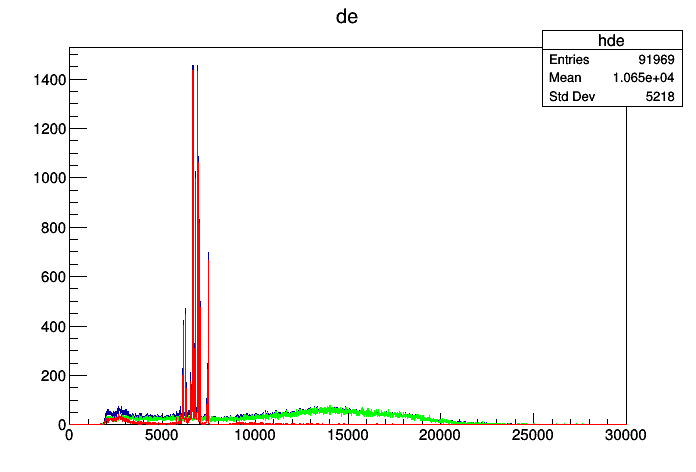

3664


In [3]:
tree->Draw("de>>hde(3000,0,30000)");//all
tree->Draw("de>>hdem(3000,0,30000)","me>0");//coincide with mwpc
tree->Draw("de>>hdenm(3000,0,30000)","me<0");//mwpc veto
TH1F *hde, *hdem, *hdenm;
hde=(TH1F*)gROOT->FindObject("hde");
hdem=(TH1F*)gROOT->FindObject("hdem");
hdenm=(TH1F*)gROOT->FindObject("hdenm");
hde->Draw();
hdem->SetLineColor(kGreen);
hdenm->SetLineColor(kRed);
hdem->Draw("same");
hdenm->Draw("same");
c1->Draw();
cout<<hdem->Integral(600,750)<<endl;

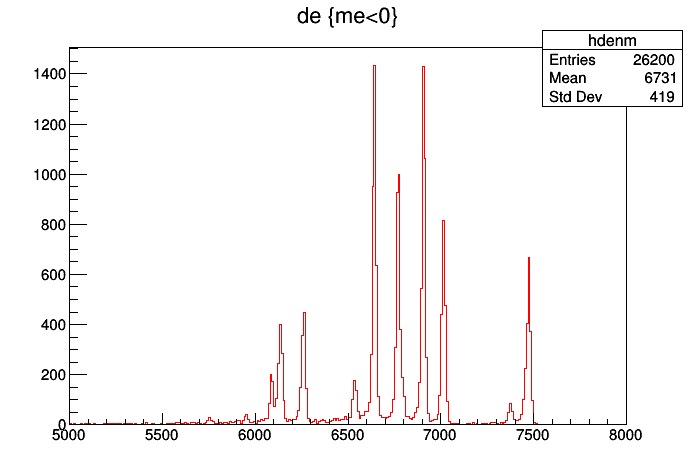

In [4]:
hdenm->GetXaxis()->SetRangeUser(5000,8000);
hdenm->Draw();
c1->Draw();

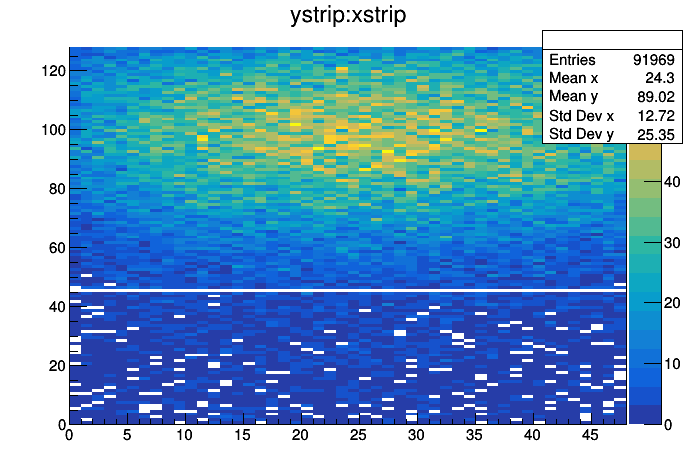

In [5]:
tree->Draw("ystrip:xstrip>>(48,0,48,128,0,128)","","colz");
c1->SetLogy(0);
c1->SetLogz(0);
c1->Draw();

## 按照mwpc上的能量对事件进行分类
- 重离子(Implantation) me>0
- 衰变粒子(Decay) me<0

In [6]:
struct dssd
{
    Float_t energy;
    Int_t xstrip,ystrip;
};
dssd ds;
map<ULong64_t, dssd> mapimp, mapdec;//implantaion, decay

Long64_t nentries = tree->GetEntriesFast();
for (Long64_t jentry=0; jentry<nentries;jentry++) {
    tree->GetEntry(jentry);
        ds.energy = de;
        ds.xstrip = xstrip;
        ds.ystrip = ystrip;
    if(me>0) mapimp.insert(pair<ULong64_t,dssd>(timestamp,ds));
    else mapdec.insert(pair<ULong64_t,dssd>(timestamp,ds));
}
cout<<"The number of implantation/decay : "<<mapimp.size()<<"  "<<mapdec.size()<<endl;

The number of implantation/decay : 65769  26200


## 重离子与衰变事件的关联
- 由于束流在DSSD上有着很宽的位置分布(通过调束，使得束流在注入探测器上有着较宽的分布)，且DSSD的每个pixel面积很小，可以认为在重离子强度不高时，重离子注入到某一颗粒后在一段不长的时间范围内，该颗粒上发生的衰变事件都是由该重离子的衰变产生的。换句话说，可将DSSD探测器看成由 $x \times y$ 个独立的探测单元，每个单元在一段时间内只有一个重离子($t=t_0$)注入，并发生衰变($t=t_d$)（图.a）。此时衰变和注入事件之间的时间差$\delta t=t_d-t_0$，服从指数衰减分布，衰减常数由重离子的半衰期决定。当该单元上发生的衰变事件($t=t_d'$)不是来源于上一个重离子衰变，而是由其他时间内注入的其他重离子($t<t_0$)的衰变引起 (图.b)，那么这些事件的衰变-重离子之间不存在上述关联，其时间差 $t_d'-t_0$在时间轴上均匀分布。上述将不同时刻发生的重离子和衰变事件关联起来的方法称为position-time correlation for implantation and decay events。
![](correlation.png)


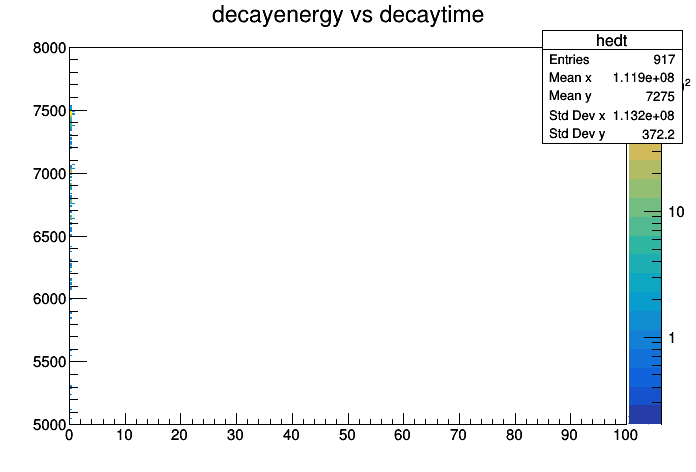

In [7]:
ULong64_t twindow = 100000000000;//1s
TH2F *hedt=new TH2F("hedt","decayenergy vs decaytime",200,0,1e11,300,5000,8000);
for(auto ia=mapimp.begin(); ia!=mapimp.end();ia++) {
     auto ib=mapdec.lower_bound(ia->first);
    while(ib != mapdec.end()) {
        if(abs(ib->second.xstrip-ia->second.xstrip)>1) break;
        if(abs(ib->second.ystrip-ia->second.ystrip)>1) break;
        if(ib->first >= ia->first + twindow) break;
        ULong64_t decaytime = ib->first - ia->first;
        hedt->Fill(decaytime,ib->second.energy);
        ib++;
    }   
}
hedt->Draw("colz");
c1->SetLogz();
c1->Draw();

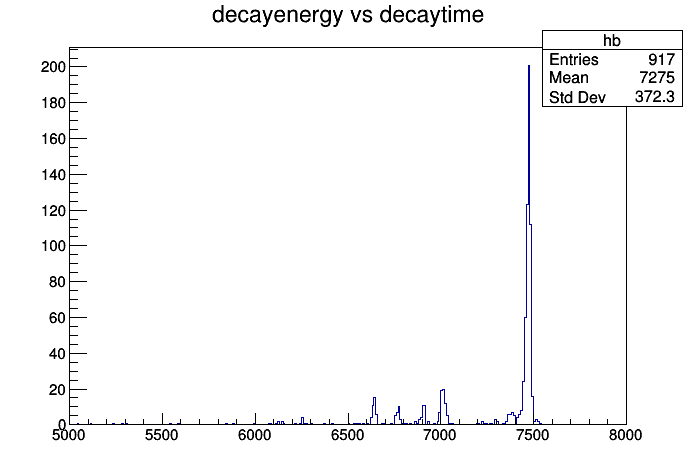

In [8]:
TH1F *hb=(TH1F*)hedt->ProjectionY("hb");
hb->Draw();
c1->Draw();

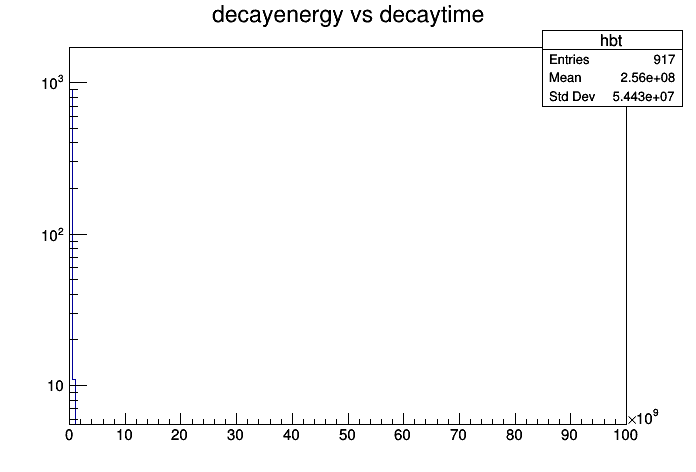

In [9]:
TH1F *hbt=(TH1F*)hedt->ProjectionX("hbt");
hbt->Draw();
c1->SetLogy();
c1->Draw();